In [1]:
from functools import lru_cache

import numpy as np
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.stats.gp.upcross import gp_upcross_at_level
from sigcorr.tools.stats.utils import sig2pval
from sigcorr.tools.stats.utils import pval2sig

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import OverflowsCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.tools.visual import plot_norm_pulls

CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size
set_plt_reasonable_defaults(plt)

In [2]:
input_file = "../../output/hyy_dense121-1m.h5"

In [3]:
true_res_part = {}
with h5py.File(input_file, "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "sb_successes", "b_successes"]:
        true_res_part[field] = f[field][:100000, ...]
    true_res_part["scan_xs"] = f["scan_xs"][...]

In [4]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:19<00:00, 52240.70it/s]


In [5]:
@lru_cache
def get_asimov_by_tag(tag):
    asimov_template = input_file.split("-")[0]+"-asimov_{}.h5"
    
    asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_template.format(tag), ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
    asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
    asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))
    return asimov_covcalc

def get_asimov_by_tags(tags):
    res_asimov_cov = np.array(0)
    tot_n = 0
    for tag in tags:
        str_tag = f"{abs(tag)}sigma"
        str_tag = f"{str_tag}_neg" if tag < 0 else str_tag
        covcalc = get_asimov_by_tag(str_tag)
        res_asimov_cov = res_asimov_cov + covcalc.get_cov(override_x=np.array(0))*covcalc.n
        tot_n += covcalc.n
    res_asimov_cov /= tot_n
    stds = np.sqrt(np.diagonal(res_asimov_cov)).ravel()
    return res_asimov_cov/(stds[:, np.newaxis]*stds)

def gp_p0(cov, c0, num=1_000_000):
    if c0 < 3.5:
        asimov_gp_p0_bs, _ = get_last_from_iter(gp_batch_mapreduce(cov, num, 10_000, true_res_part["scan_xs"].shape, OverflowsCalc([c0]), BatchStats1Reduce()))
        asimov_gp_p0, asimov_gp_p0_err = asimov_gp_p0_bs.get_mean(), asimov_gp_p0_bs.get_stat_err()    
    else:
        asimov_gp_p0 = gp_upcross_at_level(true_res_part["scan_xs"].ravel(), cov, c0)
    return asimov_gp_p0

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 29799.61it/s]


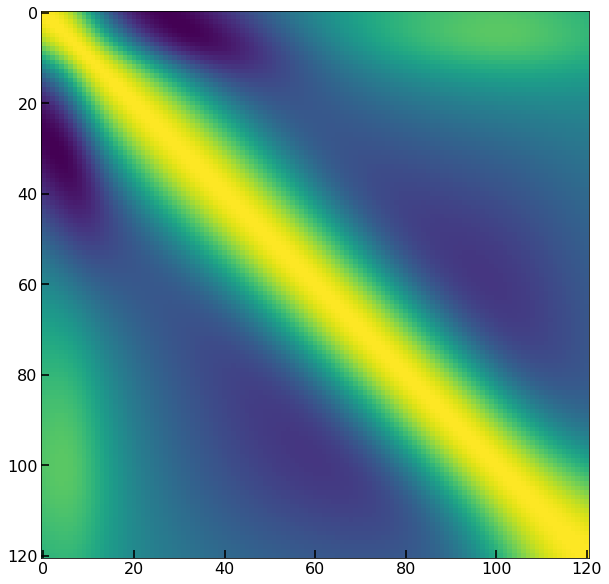

In [6]:
plt.imshow(get_asimov_by_tags([-1,-2,-3,-4,1,2,3,4]))

In [7]:
bf_gp_p0_bs, _ = get_last_from_iter(gp_batch_mapreduce(true_cov, 1000_000, 10_000, true_res_part["scan_xs"].shape[:-1], OverflowsCalc([5]), BatchStats1Reduce()))
bf_gp_p0, bf_gp_p0_err = bf_gp_p0_bs.get_mean(), bf_gp_p0_bs.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:04<00:00, 243050.51it/s]


In [8]:
tag_list = [[1, -1], [1, -1, 2, -2], [1, -1, 2, -2, 3, -3], [1, -1, 2, -2, 3, -3, 4, -4]]
sigs = np.arange(1, 5, 0.5)
num = 1_000_000

res1 = np.vstack([np.hstack([gp_p0(get_asimov_by_tags(tags), c0, num)  for tags in tag_list]) for c0 in sigs])
res2 = np.vstack([np.hstack([gp_p0(get_asimov_by_tags(tags), c0, num)  for tags in tag_list]) for c0 in sigs])
res3 = np.vstack([np.hstack([gp_p0(get_asimov_by_tags(tags), c0, num)  for tags in tag_list]) for c0 in sigs])
res4 = np.vstack([np.hstack([gp_p0(get_asimov_by_tags(tags), c0, num)  for tags in tag_list]) for c0 in sigs])
res5 = np.vstack([np.hstack([gp_p0(get_asimov_by_tags(tags), c0, num)  for tags in tag_list]) for c0 in sigs])

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 1127289.25it/s]


In [9]:
p0_loc = sig2pval(np.arange(1, 5, 0.5))

In [10]:
true_res_1 = np.hstack([gp_p0(true_cov, c0, num) for c0 in np.arange(1, 5, 0.5)])
true_res_2 = np.hstack([gp_p0(true_cov, c0, num) for c0 in np.arange(1, 5, 0.5)])
true_res_3 = np.hstack([gp_p0(true_cov, c0, num) for c0 in np.arange(1, 5, 0.5)])
true_res_4 = np.hstack([gp_p0(true_cov, c0, num) for c0 in np.arange(1, 5, 0.5)])
true_res_5 = np.hstack([gp_p0(true_cov, c0, num) for c0 in np.arange(1, 5, 0.5)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 1243307.48it/s]


In [11]:
true_res_mean = np.mean([true_res_1, true_res_2, true_res_3, true_res_4, true_res_5], axis=0)
true_res_err = np.std([true_res_1, true_res_2, true_res_3, true_res_4, true_res_5], axis=0)/np.sqrt(5)

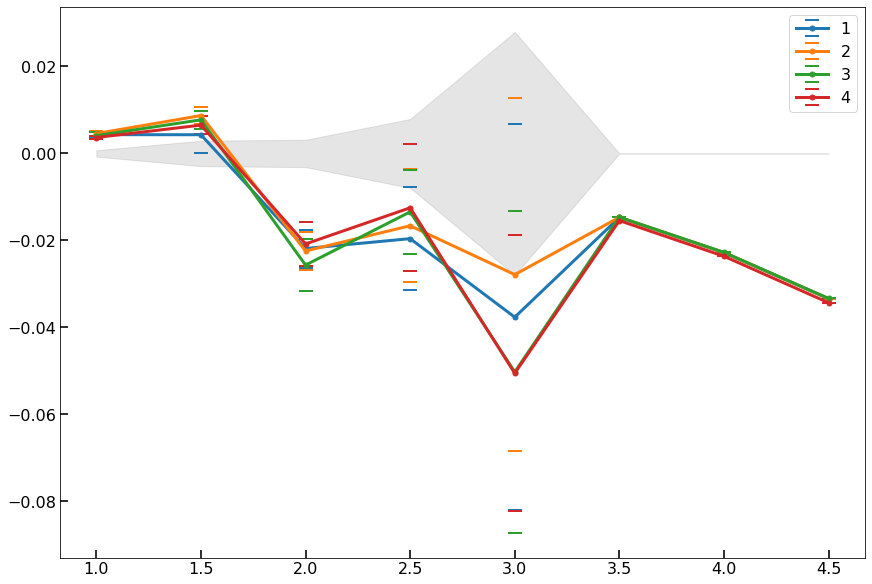

In [12]:
for i in range(4):
    plt.errorbar(np.arange(1, 5, 0.5), (np.mean([res1, res2, res3, res4, res5], axis=0)[:, i] - true_res_mean)/p0_loc, yerr=np.std([res1, res2, res3, res4, res5], axis=0)[:, i]/np.sqrt(5)/p0_loc, marker="o", elinewidth=0, capthick=2, capsize=7, label=i+1)
plt.fill_between(np.arange(1, 5, 0.5), -true_res_err/p0_loc, true_res_err/p0_loc, color="gray", alpha=0.2)
plt.legend()